In [1]:
!pip install split-folders

In [2]:
%config Completer.use_jedi = False

In [3]:
import numpy as np 
import pandas as pd
import random
import os
import glob as gb
import cv2
import shutil
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import time
import copy
from pathlib import Path
import splitfolders

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

In [4]:
input_folder = '../input/cottonweedid15/CottonWeedID15/'

subfolders = os.listdir(input_folder)
subfolders

['Nutsedge',
 'Sicklepod',
 'Morningglory',
 'Ragweed',
 'PalmerAmaranth',
 'Waterhemp',
 'Crabgrass',
 'Swinecress',
 'Prickly Sida',
 'Carpetweeds',
 'SpottedSpurge',
 'SpurredAnoda',
 'Eclipta',
 'Goosegrass',
 'Purslane']

In [5]:
input_folder = "../input/cottonweedid15/CottonWeedID15"
output = "./" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 5187 files [02:05, 41.21 files/s]


In [6]:
image_dir = Path('../input/cottonweedid15/CottonWeedID15')

# Get filepaths and labels
filepaths_jpg = list(image_dir.glob(r'**/*.jpg'))
filepaths_png = list(image_dir.glob(r'**/*.JPG'))
filepaths_jpeg= list(image_dir.glob(r'**/*.jpeg'))


filepaths_1 = pd.Series(filepaths_jpg, name='Filepath').astype(str)
filepaths_2 = pd.Series(filepaths_png, name='Filepath').astype(str)
filepaths_3 = pd.Series(filepaths_jpeg, name='Filepath').astype(str)
filepath = filepaths_1.append(filepaths_2,ignore_index=True)
filepaths = filepath.append(filepaths_3,ignore_index=True)

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.reset_index(drop = True)

In [7]:
# Show the result
image_df.head(3)

,Filepath,Label
0,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge
1,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge
2,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge


In [8]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5187 entries, 0 to 5186
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  5187 non-null   object
 1   Label     5187 non-null   object
dtypes: object(2)
memory usage: 81.2+ KB


In [9]:
print(len(image_df))

5187


In [10]:
image_df['Label'].value_counts()

Morningglory      1115
Carpetweeds        763
PalmerAmaranth     689
Waterhemp          451
Purslane           450
Nutsedge           273
Eclipta            254
Sicklepod          240
SpottedSpurge      234
Goosegrass         216
Ragweed            129
Prickly Sida       129
Crabgrass          111
Swinecress          72
SpurredAnoda        61
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

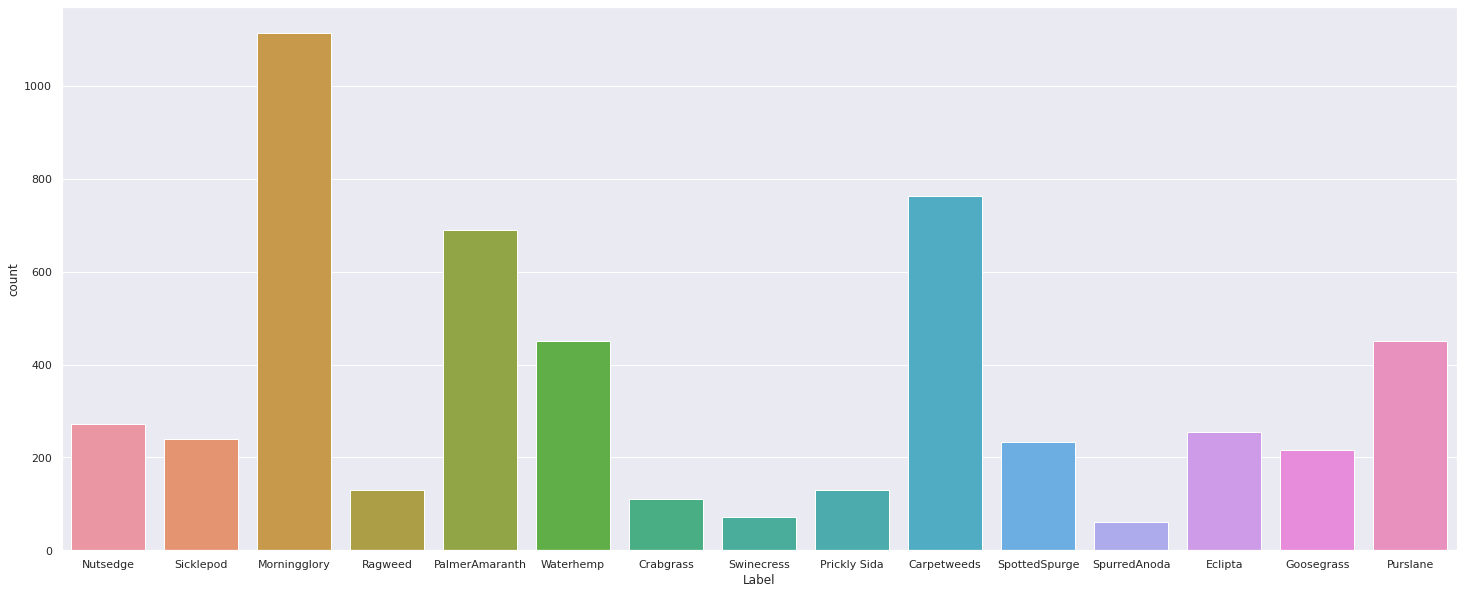

In [11]:
sns.set(rc={'figure.figsize':(25,10)})
sns.countplot(data=image_df, x="Label")

In [12]:
# Set the id as the index in df_data
image_df.reset_index(inplace=True)

In [13]:
# Show the result
image_df.head(3)

,index,Filepath,Label
0,0,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge
1,1,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge
2,2,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge


In [14]:
training_path = './train'
validation_path = './val'
testing_path = './test'

IMG_DIMENSIONS = (224, 224)
BATCH_SIZE = 32

# Set Up the Generators

In [15]:
def create_flows():
    # Load the Images with a generator and Data Augmentation
    data_generator = ImageDataGenerator(
        rescale=1.0/255,
        validation_split=0.1
    )


    train_ds = tensorflow.keras.utils.image_dataset_from_directory(
    training_path,
    subset="training",
    validation_split = 0.2,
    seed = 123,
    image_size = IMG_DIMENSIONS,
    batch_size = BATCH_SIZE)

    val_ds = tensorflow.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.2,
    subset="validation",
    seed = 123,
    image_size = IMG_DIMENSIONS,
    batch_size = BATCH_SIZE)

    test_ds = tensorflow.keras.utils.image_dataset_from_directory(
    testing_path,
    label_mode = None,
    seed = 123,
    image_size = IMG_DIMENSIONS,
    batch_size = BATCH_SIZE,
    shuffle = False)

    
    return data_generator,train_ds,val_ds,test_ds

In [16]:
datagen, train_ds, val_ds, test_ds = create_flows()

Found 4144 files belonging to 15 classes.
Using 3316 files for training.


2022-10-31 16:25:28.644462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:25:28.836773: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:25:28.837762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-31 16:25:28.841428: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 4144 files belonging to 15 classes.
Using 828 files for validation.
Found 530 files belonging to 1 classes.


In [17]:
AUTOTUNE = tensorflow.data.AUTOTUNE
def prepare_dataset(ds):
    def input_preprocess(image, label):
        label = tensorflow.one_hot(label, 15)
        return image, label
    ds = ds.map(input_preprocess, num_parallel_calls = AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size = AUTOTUNE)
    return ds

In [18]:
train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Create the Model Architecture

In [19]:

# CNN structure parameters
kernel_size = (3,3)
pool_size= (2,2)

dropout_conv = 0.3
dropout_dense = 0.2


model = Sequential()
model.add(Conv2D(32, kernel_size, activation = 'relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(64, kernel_size, activation ='relu'))
model.add(Conv2D(64, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(64, kernel_size, activation ='relu'))
model.add(Conv2D(64, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(15, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0

# Train the Model

In [20]:
model.compile(Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [21]:
checkpoint = ModelCheckpoint(filepath='/kaggle/working/Best_model.h5', monitor='val_loss', verbose=0, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss', patience=2,  
                           mode='auto', 
                           restore_best_weights=True)
                                 
callbacks_list = [early_stop, checkpoint, reduce_lr]

In [22]:
 history = model.fit(train_ds, 
                     validation_data = val_ds, 
                     batch_size = 32, 
                     epochs=40,
                     callbacks=callbacks_list)

2022-10-31 16:25:33.749689: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-10-31 16:25:34.570972: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 34798080 exceeds 10% of free system memory.
2022-10-31 16:25:34.652782: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30385950 exceeds 10% of free system memory.
2022-10-31 16:25:34.675513: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 43387740 exceeds 10% of free system memory.
2022-10-31 16:25:34.781420: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30581712 exceeds 10% of free system memory.
2022-10-31 16:25:35.011558: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 55812000 exceeds 10% of free system memory.
2022-10-31 16:25:44.504163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 219 of 256
2022-10-31 16:25:45.900141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-10-31 16:25:48.445191: I tensorflow/st

104/104 [==============================] - ETA: 0s - loss: 9.8398 - accuracy: 0.1535

2022-10-31 16:28:18.531186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 219 of 256
2022-10-31 16:28:20.273362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


104/104 [==============================] - 192s 2s/step - loss: 9.8398 - accuracy: 0.1535 - val_loss: 2.5944 - val_accuracy: 0.2126
Epoch 2/40
104/104 [==============================] - 6s 59ms/step - loss: 2.5073 - accuracy: 0.1674 - val_loss: 2.5912 - val_accuracy: 0.2234
Epoch 3/40
104/104 [==============================] - 6s 60ms/step - loss: 2.4550 - accuracy: 0.1921 - val_loss: 2.5581 - val_accuracy: 0.2114
Epoch 4/40
104/104 [==============================] - 6s 59ms/step - loss: 2.3982 - accuracy: 0.2232 - val_loss: 2.4688 - val_accuracy: 0.1969
Epoch 5/40
104/104 [==============================] - 6s 59ms/step - loss: 2.3493 - accuracy: 0.2265 - val_loss: 2.4473 - val_accuracy: 0.2343
Epoch 6/40
104/104 [==============================] - 6s 60ms/step - loss: 2.3154 - accuracy: 0.2539 - val_loss: 2.4243 - val_accuracy: 0.2246
Epoch 7/40
104/104 [==============================] - 6s 59ms/step - loss: 2.2750 - accuracy: 0.2572 - val_loss: 2.3998 - val_accuracy: 0.2319
Epoch 8/40